# Movies Reviews Sentiment Analysis - Extended

Extendemos el set utilizando los datos de clase (Franco Luque hint @slackware)

In [1]:
%load_ext autoreload
%autoreload 2
#
import pandas as pd
import numpy as np
#
from util import print_plot_classification_report
from util import  load_model,save_model
from util import eval
from util import iterate_pipeline_params    
#
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
#
from util import load_datasets_unlabeled_test
from util import load_datasets

### Data

In [39]:
###
train, dev, test = load_datasets_unlabeled_test(test_size_val=0.30) # en realidad dev_size_val
X_train, y_train = train
X_dev, y_dev = dev
X_test=test  # No tenemos el correspondiente y_test
####
train_e, dev_e, test_e = load_datasets()
X_train_e, y_train_e = train_e
X_dev_e, y_dev_e = dev_e
X_test_e, y_test_e = test_e

In [40]:
X_train_f=[]
X_train_f.extend(X_train)
X_train_f.extend(X_train_e)
X_train_f.extend(X_dev_e)
X_train_f.extend(X_test_e)
y_train_f=np.concatenate((y_train,y_train_e,y_dev_e,y_test_e))


## TfidfVectorizer Approach

### LogisticRegressionCV

Train using <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
Reporte de clasificación: 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1362
          1       1.00      1.00      1.00      1387

avg / total       1.00      1.00      1.00      2749





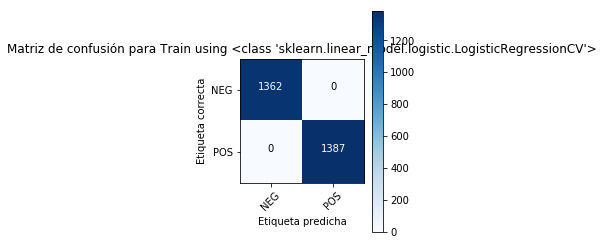

Dev using <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
Reporte de clasificación: 

             precision    recall  f1-score   support

          0       0.86      0.86      0.86       173
          1       0.83      0.83      0.83       148

avg / total       0.84      0.84      0.84       321





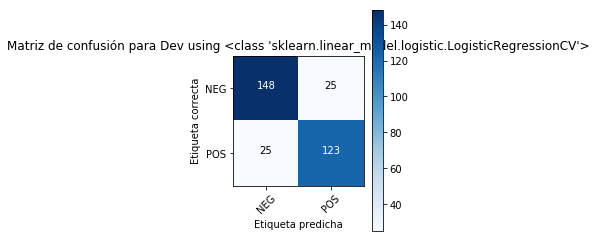

In [41]:
X_case=X_train_f;y_case=y_train_f;y_case_dev=y_dev; X_case_dev=X_dev
#
vect = TfidfVectorizer()
clf = LogisticRegressionCV()

pipeline = Pipeline([
    ('vect', vect),
    ('clf', clf),
])
#
pipeline.fit(X_case,y_case)
est=str(pipeline.steps[-1][1].__class__)
# Train
print_plot_classification_report(pipeline,X_case,y_case,'Train using ' + est,plotFlag=True,classes_list=['NEG','POS'])
# Dev
print_plot_classification_report(pipeline,X_case_dev,y_case_dev,'Dev using ' + est,plotFlag=True,classes_list=['NEG','POS'])

### LogisticRegressionCV - ParamsGrid

In [48]:
param_grid = {
    'vect__binary': [True],
    'vect__ngram_range': [(1, 1)],
    'vect__min_df': [1],
    'vect__max_df':[0.95] ,
    'clf__random_state': [0],
    'clf__scoring':['accuracy'],
    'clf__n_jobs':[-1],
    'clf__Cs':[5],
    'clf__cv':[5],
}
params_list = list(ParameterGrid(param_grid))
vect = TfidfVectorizer()
clf = LogisticRegressionCV()

pipeline = Pipeline([
    ('vect', vect),
    ('clf', clf),
])

In [49]:
X_case=X_train_f;y_case=y_train_f;y_case_dev=y_dev;X_case_dev=X_dev
results=iterate_pipeline_params(pipeline,params_list,X_case,y_case,X_case_dev, y_dev)
# results to Pandas
results_df = pd.DataFrame(results)
results_df.sort_values(['acc', 'f1'], ascending=False)[:5]

acc  clf__Cs  clf__cv  clf__n_jobs  clf__random_state clf__scoring  \
0  0.859813        5        5           -1                  0     accuracy   

         f1  vect__binary  vect__max_df  vect__min_df vect__ngram_range  
0  0.859151          True          0.95             1            (1, 1)

Case using <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
Reporte de clasificación: 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1419
          1       1.00      1.00      1.00      1437

avg / total       1.00      1.00      1.00      2856





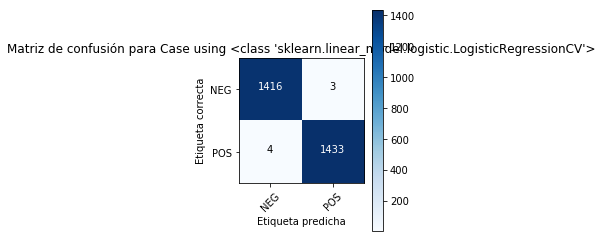

Dev using <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
Reporte de clasificación: 

             precision    recall  f1-score   support

          0       0.91      0.91      0.91       116
          1       0.89      0.89      0.89        98

avg / total       0.90      0.90      0.90       214





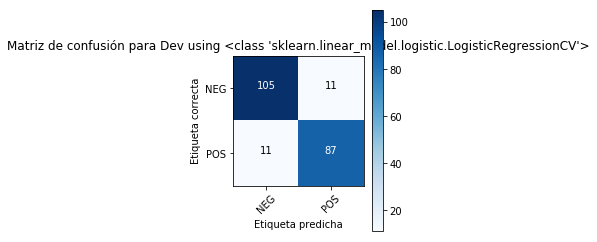

In [8]:
save_flag=False
#
idx=0
vect = TfidfVectorizer()
clf = LogisticRegressionCV()
pipeline = Pipeline([
    ('vect', vect),
    ('clf', clf),
])
params_=dict(results_df.iloc[idx].drop(['acc','f1']))
pipeline.set_params(**params_)
pipeline.fit(X_case,y_case)
if save_flag:
    save_model(pipeline,'pipe_tv_logregcv_iteparams_extended_dummy')
est=str(pipeline.steps[-1][1].__class__)
# Train
print_plot_classification_report(pipeline,X_case,y_case,'Case using ' + est,plotFlag=True,classes_list=['NEG','POS'])
# Dev
print_plot_classification_report(pipeline,X_case_dev,y_case_dev,'Dev using ' + est,plotFlag=True,classes_list=['NEG','POS'])

### GridSearch Approach

En general esto no resulto muy benefico....

In [41]:
param_grid = {
    'vect__binary': [True],
    'vect__ngram_range': [(1, 1)],
    'vect__min_df': [1],
    'vect__max_df': [1.0],
    'vect__use_idf': [True],  
    'vect__sublinear_tf': [False], 
    'clf__random_state': [0],
    'clf__C': [1,100],
}


In [42]:
X_case=X_train_f;y_case=y_train_f
from sklearn.svm import LinearSVC
from util import print_GridSearch_params
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
#
vect = TfidfVectorizer()
clf = LogisticRegression()

pipeline = Pipeline([
    ('vect', vect),
    ('clf', clf),
])
#
grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=param_grid, scoring='accuracy')
grid.fit(X_case, y_case)
# Print GridSearch
print_GridSearch_params(grid,'TRAIN_DEV_CV',fullprint=False)
print('GRID - BEST SCORE')
print(grid.best_score_)

TRAIN_DEV_CV
Mejor conjunto de parámetros para GridSearch en TRAIN_DEV_CV :
{'clf__C': 100, 'clf__random_state': 0, 'vect__binary': True, 'vect__max_df': 1.0, 'vect__min_df': 1, 'vect__ngram_range': (1, 1), 'vect__sublinear_tf': False, 'vect__use_idf': True}

GRID - BEST SCORE
0.8646643109540636


### ParamGrid - LogisticRegressionCV II -SET II

In [70]:
# Cargamos el dataset
###
train, dev, test = load_datasets_unlabeled_test(test_size_val=0.20) # en realidad dev_size_val
X_train, y_train = train
X_dev, y_dev = dev
X_test=test  # No tenemos el correspondiente y_test
####
train_e, dev_e, test_e = load_datasets(test_size_val=0.2,dev_size_val=0.1)
X_train_e, y_train_e = train_e
X_dev_e, y_dev_e = dev_e
X_test_e, y_test_e = test_e

#### 
X_train_f=[]
X_train_f.extend(X_train)
X_train_f.extend(X_dev)
X_train_f.extend(X_train_e)
X_train_f.extend(X_test_e)
y_train_f=np.concatenate((y_train,y_dev,y_train_e,y_test_e))


In [71]:
param_grid = {
    'vect__binary': [True],
    'vect__ngram_range': [(1, 1)],
    'vect__min_df': [1],
    'vect__max_df':[1.0,0.9] ,
    'clf__random_state': [0],
    'clf__scoring':['accuracy'],
    'clf__n_jobs':[-1],
    'clf__Cs':[10],
    'clf__cv':[5],
}
params_list = list(ParameterGrid(param_grid))
vect = TfidfVectorizer()
clf = LogisticRegressionCV()

pipeline = Pipeline([
    ('vect', vect),
    ('clf', clf),
])

In [72]:
X_case=X_train_f;y_case=y_train_f; y_case_dev=y_dev_e; X_case_dev=X_dev_e
results=iterate_pipeline_params(pipeline,params_list,X_case,y_case,X_case_dev, y_case_dev)
# results to Pandas
results_df = pd.DataFrame(results)
results_df.sort_values(['acc', 'f1'], ascending=False)[:5]

acc  clf__Cs  clf__cv  clf__n_jobs  clf__random_state clf__scoring  \
0  0.94375       10        5           -1                  0     accuracy   
1  0.94375       10        5           -1                  0     accuracy   

         f1  vect__binary  vect__max_df  vect__min_df vect__ngram_range  
0  0.943483          True           1.0             1            (1, 1)  
1  0.943483          True           0.9             1            (1, 1)

Case using <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
Reporte de clasificación: 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1406
          1       1.00      1.00      1.00      1424

avg / total       1.00      1.00      1.00      2830





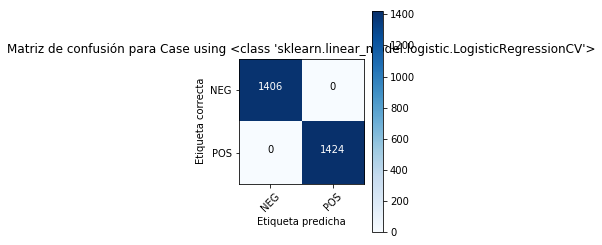

Dev using <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
Reporte de clasificación: 

             precision    recall  f1-score   support

          0       0.94      0.92      0.93       129
          1       0.91      0.93      0.92       111

avg / total       0.93      0.93      0.93       240





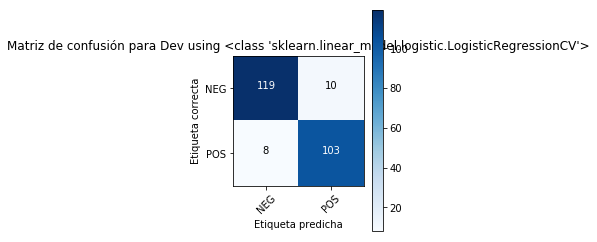

In [60]:
from util import print_plot_classification_report
from util import  load_model,save_model
save_flag=False
#
idx=0
vect = TfidfVectorizer()
clf = LogisticRegressionCV()
pipeline = Pipeline([
    ('vect', vect),
    ('clf', clf),
])
params_=dict(results_df.iloc[idx].drop(['acc','f1']))
pipeline.set_params(**params_)
pipeline.fit(X_case,y_case)
if save_flag:
    save_model(pipeline,'pipe_tv_logregcv_iteparams_extended_sort_dummy_e')
est=str(pipeline.steps[-1][1].__class__)
# Train
print_plot_classification_report(pipeline,X_case,y_case,'Case using ' + est,plotFlag=True,classes_list=['NEG','POS'])
# Dev
print_plot_classification_report(pipeline,X_case_dev,y_case_dev,'Dev using ' + est,plotFlag=True,classes_list=['NEG','POS'])

## Full Merge

In [45]:
# Cargamos el dataset
import numpy as np
from util import load_datasets_unlabeled_test
from util import load_datasets
train, dev, test = load_datasets_unlabeled_test(test_size_val=0.20) # en realidad dev_size_val
X_train, y_train = train
X_dev, y_dev = dev
X_test=test  # No tenemos el correspondiente y_test

# Original review polarity
train_e, dev_e, test_e = load_datasets(test_size_val=0.2,dev_size_val=0.15)
X_train_e, y_train_e = train_e
X_dev_e, y_dev_e = dev_e
X_test_e, y_test_e = test_e

X_train_f=[]
X_train_f.extend(X_train); X_train_f.extend(X_dev); 
X_train_f.extend(X_train_e); X_train_f.extend(X_dev_e);
X_train_f.extend(X_test_e)
y_train_f=np.concatenate((y_train,y_dev,y_train_e,y_dev_e,y_test_e))

from sklearn.model_selection import train_test_split
X_train_s, X_dev_s, y_train_s, y_dev_s = train_test_split(X_train_f, y_train_f, test_size=0.2, random_state=0)

In [53]:
import numpy as np
param_grid = {
    'vect__binary': [True],
    'vect__ngram_range': [(1, 1)],
    'vect__min_df': [1],
    'vect__max_df':[0.97,0.95] ,
    'clf__random_state': [0],
    'clf__scoring':['accuracy'],
    'clf__class_weight':['balanced'],
    'clf__n_jobs':[-1],
    'clf__Cs':[10],
    'clf__cv':[10],
}
params_list = list(ParameterGrid(param_grid))
vect = TfidfVectorizer()
clf = LogisticRegressionCV()

pipeline = Pipeline([
    ('vect', vect),
    ('clf', clf),
])

In [54]:
X_case=X_train_s;y_case=y_train_s; y_case_dev=y_dev_s; X_case_dev=X_dev_s
results=iterate_pipeline_params(pipeline,params_list,X_case,y_case,X_case_dev, y_case_dev)
# results to Pandas
results_df = pd.DataFrame(results)
results_df.sort_values(['acc', 'f1'], ascending=False)[:5]

acc  clf__Cs clf__class_weight  clf__cv  clf__n_jobs  \
0  0.884365       10          balanced       10           -1   
1  0.884365       10          balanced       10           -1   

   clf__random_state clf__scoring        f1  vect__binary  vect__max_df  \
0                  0     accuracy  0.884313          True          0.97   
1                  0     accuracy  0.884313          True          0.95   

   vect__min_df vect__ngram_range  
0             1            (1, 1)  
1             1            (1, 1)

Case using <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
Reporte de clasificación: 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1219
          1       1.00      1.00      1.00      1237

avg / total       1.00      1.00      1.00      2456





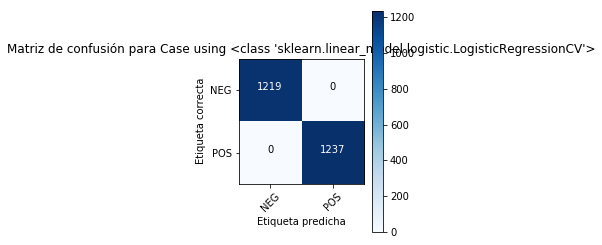

Dev using <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
Reporte de clasificación: 

             precision    recall  f1-score   support

          0       0.89      0.88      0.89       316
          1       0.87      0.89      0.88       298

avg / total       0.88      0.88      0.88       614





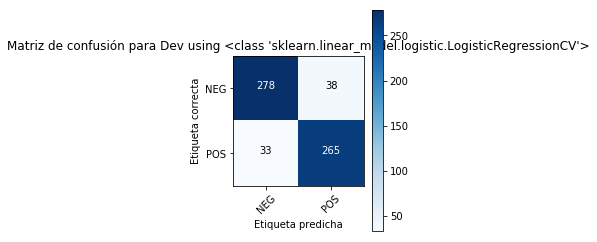

In [50]:
from util import print_plot_classification_report
from util import  load_model,save_model
save_flag=False
#
idx=1
vect = TfidfVectorizer()
clf = LogisticRegressionCV()
pipeline = Pipeline([
    ('vect', vect),
    ('clf', clf),
])
params_=dict(results_df.iloc[idx].drop(['acc','f1']))
pipeline.set_params(**params_)
pipeline.fit(X_case,y_case)
if save_flag:
    save_model(pipeline,'pipe_tv_logregcv_iteparams_extended_sort')
est=str(pipeline.steps[-1][1].__class__)
# Train
print_plot_classification_report(pipeline,X_case,y_case,'Case using ' + est,plotFlag=True,classes_list=['NEG','POS'])
# Dev
print_plot_classification_report(pipeline,X_case_dev,y_case_dev,'Dev using ' + est,plotFlag=True,classes_list=['NEG','POS'])